In [1]:
%pip install pyspark
%pip install scikit-learn
%pip install matplotlib
%pip install pandas


Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 638.2 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 1.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 462.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 1.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 1.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

import os

In [3]:
warnings.filterwarnings('ignore')

In [5]:
# Initialize Spark session
spark = SparkSession.builder.appName("CrimePatrol1").getOrCreate()

# Load dataset
crime_data = spark.read.csv("Resources/Major_Crime_Indicators_Open_Data.csv", header=True, inferSchema=True)

# Explore the dataset
crime_data.printSchema()


root
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)
 |-- OBJECTID: integer (nullable = true)
 |-- EVENT_UNIQUE_ID: string (nullable = true)
 |-- REPORT_DATE: string (nullable = true)
 |-- OCC_DATE: string (nullable = true)
 |-- REPORT_YEAR: integer (nullable = true)
 |-- REPORT_MONTH: string (nullable = true)
 |-- REPORT_DAY: integer (nullable = true)
 |-- REPORT_DOY: integer (nullable = true)
 |-- REPORT_DOW: string (nullable = true)
 |-- REPORT_HOUR: integer (nullable = true)
 |-- OCC_YEAR: integer (nullable = true)
 |-- OCC_MONTH: string (nullable = true)
 |-- OCC_DAY: integer (nullable = true)
 |-- OCC_DOY: integer (nullable = true)
 |-- OCC_DOW: string (nullable = true)
 |-- OCC_HOUR: integer (nullable = true)
 |-- DIVISION: string (nullable = true)
 |-- LOCATION_TYPE: string (nullable = true)
 |-- PREMISES_TYPE: string (nullable = true)
 |-- UCR_CODE: integer (nullable = true)
 |-- UCR_EXT: integer (nullable = true)
 |-- OFFENCE: string (nullable = true)
 |-- M

In [6]:
# Drop if exists
crime_data = crime_data.drop(crime_data.X)
crime_data = crime_data.drop(crime_data.Y)
crime_data = crime_data.drop(crime_data.OBJECTID)
crime_data = crime_data.drop(crime_data.EVENT_UNIQUE_ID)
crime_data = crime_data.drop(crime_data.REPORT_DATE)
crime_data = crime_data.drop(crime_data.REPORT_YEAR)
crime_data = crime_data.drop(crime_data.REPORT_MONTH)
crime_data = crime_data.drop(crime_data.REPORT_DAY)
crime_data = crime_data.drop(crime_data.REPORT_DOY)
crime_data = crime_data.drop(crime_data.REPORT_DOW)
crime_data = crime_data.drop(crime_data.REPORT_HOUR)
crime_data = crime_data.drop(crime_data.OCC_YEAR)
crime_data = crime_data.drop(crime_data.OCC_MONTH)
crime_data = crime_data.drop(crime_data.OCC_DAY)
crime_data = crime_data.drop(crime_data.OCC_DATE)
crime_data = crime_data.drop(crime_data.OCC_DOY)
crime_data = crime_data.drop(crime_data.DIVISION)
crime_data = crime_data.drop(crime_data.LOCATION_TYPE)
crime_data = crime_data.drop(crime_data.PREMISES_TYPE)
crime_data = crime_data.drop(crime_data.UCR_CODE)
crime_data = crime_data.drop(crime_data.UCR_EXT)
crime_data = crime_data.drop(crime_data.OFFENCE)
crime_data = crime_data.drop(crime_data.MCI_CATEGORY)
crime_data = crime_data.drop(crime_data.HOOD_158)
crime_data = crime_data.drop(crime_data.NEIGHBOURHOOD_158)
crime_data = crime_data.drop(crime_data.HOOD_140)
crime_data = crime_data.drop(crime_data.NEIGHBOURHOOD_140)


# Rename columns
crime_data = crime_data.withColumnRenamed("LONG_WGS84", "longitude")
crime_data = crime_data.withColumnRenamed("LAT_WGS84", "latitude")
crime_data = crime_data.withColumnRenamed("OCC_DOW", "dayOfTheWeek")
crime_data = crime_data.withColumnRenamed("OCC_HOUR", "hourOfTheDay")

# Remove trailing spaces from the 'dayOfTheWeek' column
crime_data = crime_data.withColumn("dayOfTheWeek", trim(crime_data["dayOfTheWeek"]))

# Define a UDF to map days to indices
day_mapping = {"Sunday": 1, "Monday": 2, "Tuesday": 3, "Wednesday": 4, "Thursday": 5, "Friday": 6, "Saturday": 7}
day_to_index_udf = udf(lambda day: day_mapping.get(day, -1), IntegerType())

# Apply the UDF to create a new column 'dayIndex'
crime_data = crime_data.withColumn("dayIndex", day_to_index_udf(col("dayOfTheWeek")))

crime_data.printSchema()
crime_data.show(15)


root
 |-- dayOfTheWeek: string (nullable = true)
 |-- hourOfTheDay: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- dayIndex: integer (nullable = true)

+------------+------------+-----------------+----------------+--------+
|dayOfTheWeek|hourOfTheDay|        longitude|        latitude|dayIndex|
+------------+------------+-----------------+----------------+--------+
|   Wednesday|           0|-79.3842059245105|43.6707982509655|       4|
|   Wednesday|           0|-79.3457948187012|43.7036843035894|       4|
|   Wednesday|          10|-79.3791313378142|43.6459808612379|       4|
|   Wednesday|           0|-79.3832001629001|43.6543126531725|       4|
|   Wednesday|           8|-79.5137965538313|43.7198240863369|       4|
|   Wednesday|           8| -79.421673390898|43.7923239909928|       4|
|   Wednesday|           9|-79.3383011325343|43.6741310288285|       4|
|   Wednesday|           4|-79.4839287578705|43.7343540636839| 

In [7]:
#drop invalid entries

#drop entries with latitude or longitude of 0 which are invalid in our data
crime_data = crime_data.filter(crime_data["latitude"] != 0)
crime_data = crime_data.filter(crime_data["longitude"] != 0)

#drop entries that were inputted with an hour outside the 24 hr clock
crime_data = crime_data.filter((col("hourOfTheDay") >= 0) & (col("hourOfTheDay") <= 23))

#drop entries without a valid day of the week
valid_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
crime_data = crime_data.filter(trim(crime_data["dayOfTheWeek"]).isin(valid_days))


crime_data.show(15)

# Write csv file and overwrite if exists
crime_data.write.option("header", "true").mode("overwrite").csv("./Cleaned")



+------------+------------+-----------------+----------------+--------+
|dayOfTheWeek|hourOfTheDay|        longitude|        latitude|dayIndex|
+------------+------------+-----------------+----------------+--------+
|   Wednesday|           0|-79.3842059245105|43.6707982509655|       4|
|   Wednesday|           0|-79.3457948187012|43.7036843035894|       4|
|   Wednesday|          10|-79.3791313378142|43.6459808612379|       4|
|   Wednesday|           0|-79.3832001629001|43.6543126531725|       4|
|   Wednesday|           8|-79.5137965538313|43.7198240863369|       4|
|   Wednesday|           8| -79.421673390898|43.7923239909928|       4|
|   Wednesday|           9|-79.3383011325343|43.6741310288285|       4|
|   Wednesday|           4|-79.4839287578705|43.7343540636839|       4|
|   Wednesday|           4|-79.4019981704324|43.6476071214313|       4|
|   Wednesday|          16|-79.4145751194734|43.7716977360472|       4|
|   Wednesday|           3|-79.1740333794421|43.7613933196769|  

k:  1  & WCSS:  4915.7922772360125
k:  2  & WCSS:  2284.229589721747
k:  3  & WCSS:  1299.1820037179914
k:  4  & WCSS:  1034.6974067063113
k:  5  & WCSS:  836.8196979119621
k:  6  & WCSS:  662.819712705217
k:  7  & WCSS:  563.0474005453696
k:  8  & WCSS:  482.8574757188363
k:  9  & WCSS:  414.4719304232734
k:  10  & WCSS:  371.41804001066396
k:  11  & WCSS:  343.37119377645763
k:  12  & WCSS:  317.5860693024576
k:  13  & WCSS:  297.6705597098578
k:  14  & WCSS:  273.15604000412975
k:  15  & WCSS:  255.53647097805177
k:  16  & WCSS:  242.6153387601206
k:  17  & WCSS:  226.530733925915
k:  18  & WCSS:  213.5018871126555
k:  19  & WCSS:  202.65330348263606


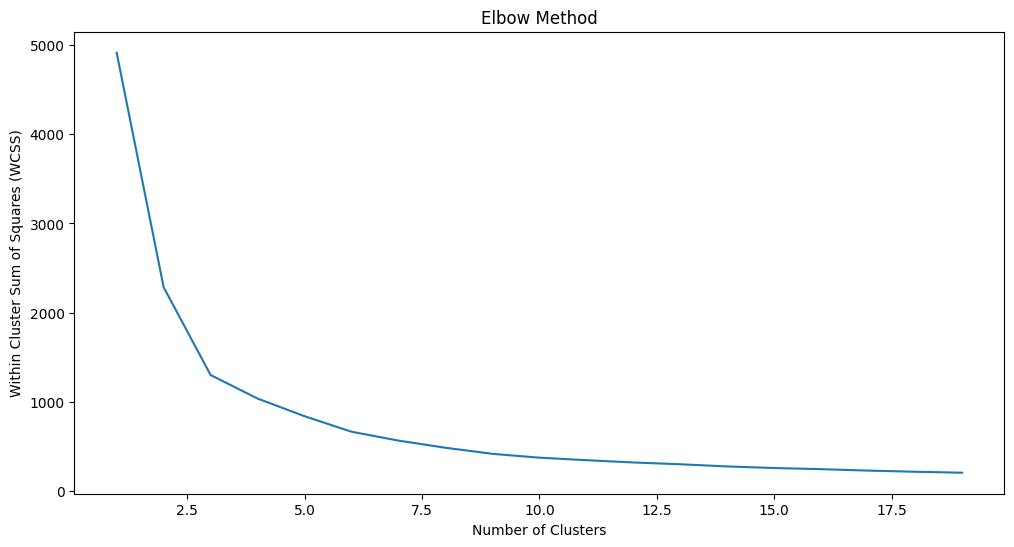

In [8]:
feature_cols = ["latitude", "longitude"]
pd_crime_data = crime_data[feature_cols].toPandas()

wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0, n_init=10)
    kmeans.fit(pd_crime_data)
    wcss.append(kmeans.inertia_)
    
    print("k: ", str(i), ' & WCSS: ', kmeans.inertia_)
    
# Plotting WCSS graph.
plt.figure(figsize=(12, 6), dpi=100)

plt.plot(range(1, 20), wcss)

plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')

plt.show()


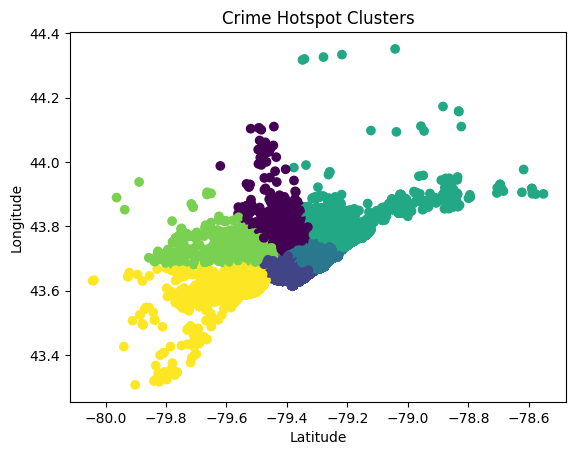

In [51]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pd_crime_data)

optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=0)
pd_crime_data["prediction"] = kmeans.fit_predict(X_scaled)


# Visualize the clusters on a map
plt.scatter(pd_crime_data['longitude'], pd_crime_data['latitude'], c=pd_crime_data['prediction'], cmap='viridis')
plt.title('Crime Hotspot Clusters')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()

In [60]:
centroids = kmeans.cluster_centers_
print(centroids)

centroids = scaler.inverse_transform(centroids)
print(centroids)

print(pd_crime_data)

[[ 1.13300867 -0.00832716 -0.64777354]
 [-0.82005691 -0.01136302  1.04088188]
 [ 0.00177708  0.92313169 -1.77354381]
 [ 1.38629107  1.51976363  0.47799674]
 [ 0.41293029 -1.26658781 -0.0848884 ]
 [-1.31757852 -1.19305099 -1.21065867]]
[[ 4.37673630e+01 -7.93988037e+01  2.00000000e+00]
 [ 4.36630542e+01 -7.93991216e+01  5.00000000e+00]
 [ 4.37069465e+01 -7.93012506e+01 -1.36335387e-13]
 [ 4.37808902e+01 -7.92387645e+01  4.00000000e+00]
 [ 4.37289052e+01 -7.95305831e+01  3.00000000e+00]
 [ 4.36364827e+01 -7.95228815e+01  1.00000000e+00]]
         latitude  longitude  prediction
0       43.670798 -79.384206           1
1       43.703684 -79.345795           2
2       43.645981 -79.379131           1
3       43.654313 -79.383200           1
4       43.719824 -79.513797           4
...           ...        ...         ...
355669  43.664737 -79.385449           1
355670  43.779054 -79.132110           3
355671  43.695252 -79.496742           4
355672  43.707053 -79.396826           1
355673 